In [1]:
import sys
sys.path.append("..")   # add the root project folder to the system path variable
from schuberts_leader.core_components import simulate_leading_indicator_data, leading_indicator_miner
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pprint import pprint

Simulate some data for us to use:

( documentation is available using `help(simulate_leading_indicator_data)` )

In [2]:
sim_explain_dict, y_arr, X_arr = simulate_leading_indicator_data(
        n_time_points = 1_000
    ,   n_predictors = 50
    ,   n_leading_indicator_effects = 10
    ,   lagged_effect_time_min_max = (1,10)
    ,   polynomial_coefs_min_max = (
        (-1,1),
        (-0.01,0.01), #(-0.002,0.002),
        (-0.0001,0.0001), #(-0.00002,0.00002),
    )
)
X_varnames = [f"X_{i}" for i in range(X_arr.shape[1])]

Have a look at a (random) few of the simulated leading relationships:

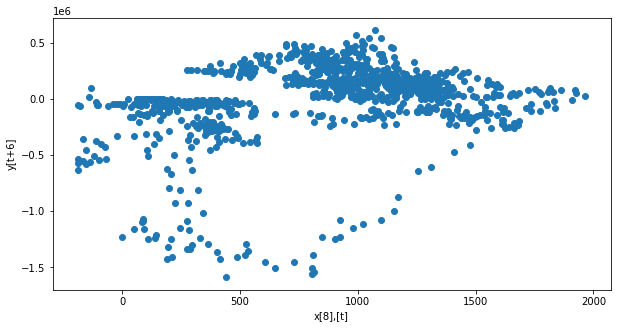

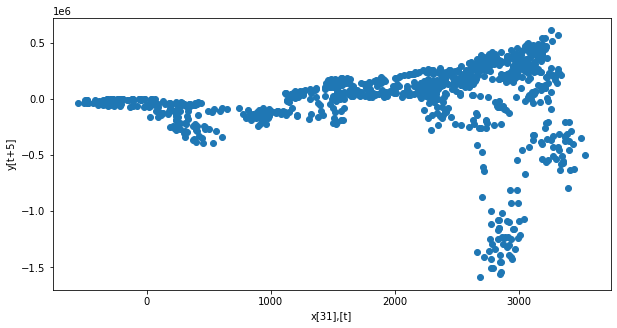

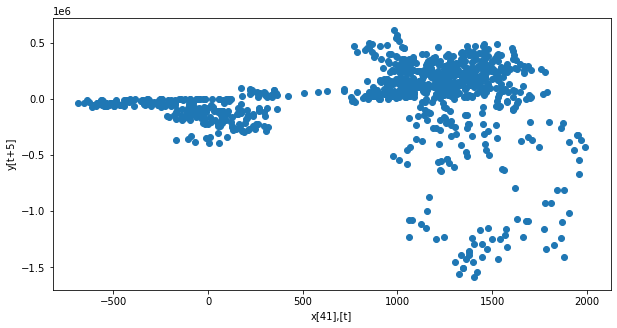

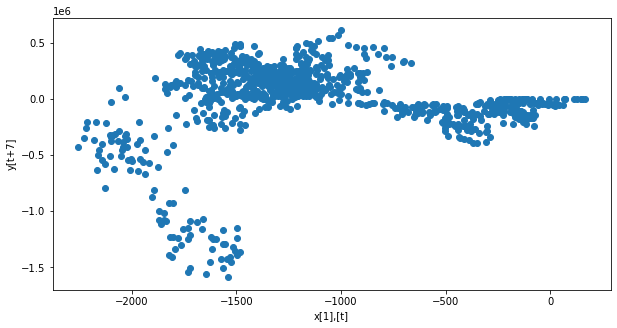

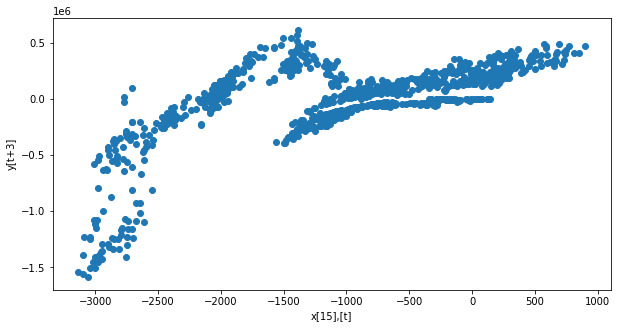

In [3]:
for k in np.random.choice(list(sim_explain_dict.keys()), size=5, replace=False):
    lag_i = sim_explain_dict[k][0]["lag"]
    plt.figure( figsize=(10,5) )
    plt.scatter( X_arr[:(len(X_arr)-lag_i),k], y_arr[lag_i:] )
    plt.xlabel( f"x[{k}],[t]" )
    plt.ylabel( f"y[t+{lag_i}]" )

split the data into a training and a test partition:

In [4]:
test_percent = 0.1
train_idx = ( 0, int((1-test_percent)*len(y_arr))-1 ) 
test_idx = (train_idx[1]+1, len(y_arr))
train_y_arr = y_arr[train_idx[0]:train_idx[1]+1] 
test_y_arr = y_arr[test_idx[0]:test_idx[1]] 
train_X_arr = X_arr[train_idx[0]:train_idx[1]+1,:] 
test_X_arr = X_arr[test_idx[0]:test_idx[1],:]

mine the data for training data for leading indicators:

In [9]:
leading_indicator_miner_model = leading_indicator_miner(n_leading_indicators=5)
leading_indicator_miner_model.fit(
    X = train_X_arr, 
    X_varnames = X_varnames, 
    y = train_y_arr, 
    y_varname = "y", 
    n_iterations = 10_000, 
    n_lags_to_consider = {'min': 1, 'max': 20}, 
    n_knots_to_consider = {'min': 10, 'max': 10}
)

iteration 10,000 of 10,000. best MSE: 11,336,886,460.383

Text(0.5, 1.0, 'Mean Squared Error on Training Data')

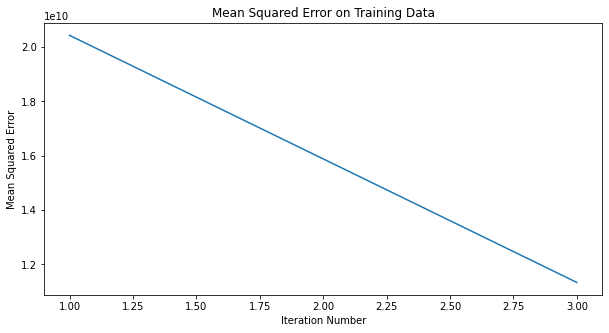

In [10]:
plt.figure( figsize=(10,5) )
plt.plot( 
    [x[0] for x in leading_indicator_miner_model.mse_history],
    [x[1] for x in leading_indicator_miner_model.mse_history],
)
plt.xlabel("Iteration Number")
plt.ylabel("Mean Squared Error")
plt.title("Mean Squared Error on Training Data")

visualize the leading indicators discovered:

In [7]:
for x in leading_indicator_miner_model.best_leading_indicators_vars_set:
    lag_i = x["lag_n_time_periods"]
    #print(x)
    #plt.figure( figsize=(10,5) )
    #plt.scatter( train_X_arr[:(len(train_X_arr)-lag_i),x], train_y_arr[lag_i:] )
    #plt.xlabel( f"x[{x}],[t]" )
    #plt.ylabel( f"y[t+{lag_i}]" )

[{'leading_indicator_varname': 'X_19',
  'mean_squared_error': 14328894533.044174,
  'lag_n_time_periods': 14,
  'n_knots': 10,
  'knot_locations': array([-707.02725507, -215.91613168,  -31.55160039,  167.76782163,
          445.14009198,  694.60516308,  868.08231904,  970.96339685,
         1189.36625073, 1408.90315574]),
  'beta_coefs': array([168234.22690622,    379.99363208,   -180.91545414,   -561.65581306,
           1147.33687992,   -872.50717571,    322.4066754 ,    830.35037233,
          -1160.80952672,   -504.59064949,    567.28573834,   -168.28418095])},
 {'leading_indicator_varname': 'X_30',
  'mean_squared_error': 14302260742.284212,
  'lag_n_time_periods': 8,
  'n_knots': 10,
  'knot_locations': array([-1.94874280e+02,  4.92880362e-01,  1.43051301e+02,  3.81794063e+02,
          7.63171501e+02,  9.22732758e+02,  1.01954487e+03,  1.10164706e+03,
          1.72340178e+03,  1.98822268e+03]),
  'beta_coefs': array([-9.96706612e+04, -1.01113655e+02,  4.40575934e+01, -1.298785

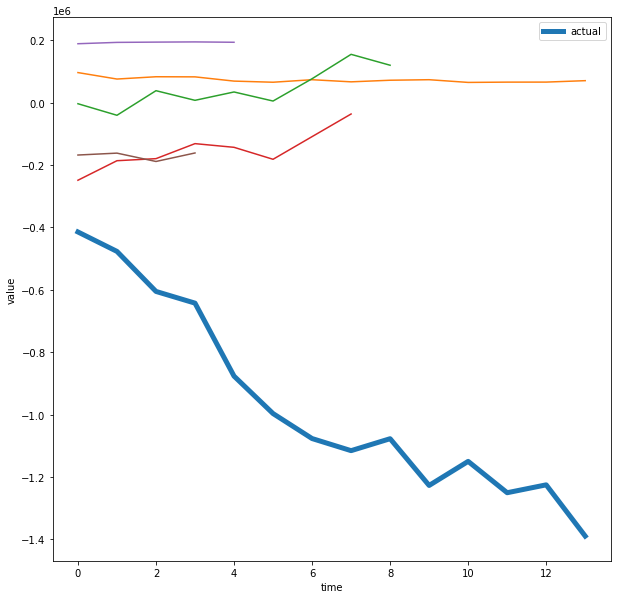

In [14]:
test_forecasts = leading_indicator_miner_model.predict(
    X = train_X_arr, 
    X_varnames = X_varnames
)
max_forecast_length = test_forecasts.shape[0]
plt.figure( figsize=(10,10) )
plt.plot( range(max_forecast_length), test_y_arr[:max_forecast_length], label="actual", linewidth=5 )
for i in range(test_forecasts.shape[1]):
    plt.plot(range(len(test_forecasts[:,i])), test_forecasts[:,i])
plt.xlabel("time")
plt.ylabel("value")
plt.legend()